# Amazon SageMaker Semantic Segmentation Algorithm

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Download data](#Download-data)
  2. [Setup data](#Setup-data)
  3. [Upload to S3](#Upload-to-S3)
4. [Training](#Training)
5. [Deployment](#Deployment)
6. [Inference](#Inference)

## Introduction

Semantic Segmentation (SS) is the task of classifying every pixel in an image with a class from a known set of labels. In contrast, [image classification](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining-highlevel.html) generates only one label per image and [object detection](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/object_detection_birds/object_detection_birds.html) generates a bounding box along with the label for each object in the image. The semantic segmentation output is usually represented as different pixel values in the image. Therefore, the output is an integer matrix (or a grayscale image) with the same shape as the input image. This output image is also called a segmentation mask. With the Amazon SageMaker Semantic Segmentation algorithm, not only can you train your models with your own dataset but also use our pre-trained models for lazy initialization.

This notebook is an end-to-end example introducing the Amazon SageMaker Semantic Segmentation algorithm. In this demo, we will demonstrate how to train and host a semantic segmentation model using the fully-convolutional network ([FCN](https://arxiv.org/abs/1605.06211)) algorithm using the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/) for training. Amazon SageMaker Semantic Segmentation also provides the option of using Pyramid Scene Parsing Network ([PSP](https://arxiv.org/abs/1612.01105)) and [Deeplab-v3](https://arxiv.org/abs/1706.05587) in addition to the FCN Network. Along the way, we will also demonstrate how to construct a training dataset in the format that the training job will consume. Finally, we will demonstrate how to host and validate the trained model.

## Setup

This notebook has been updated for [SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/) (`sagemaker`) **version 2** - which introduces some breaking changes from the v1 API. See the [migration guide](https://sagemaker.readthedocs.io/en/stable/v2.html) for details.

In this first cell we'll upgrade the SageMaker SDK installation if needed, before we `import sagemaker`. You can skip this cell if your environment as already up-to-date:

In [1]:
!pip install 'sagemaker>=2,<3'

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


To train the Semantic Segmentation algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. This role that is used to give SageMaker access to your data in S3 can automatically be obtained from the role used to start the notebook.

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::976939723775:role/service-role/AmazonSageMaker-ExecutionRole-20210317T133000
CPU times: user 785 ms, sys: 774 ms, total: 1.56 s
Wall time: 760 ms


We also need the S3 bucket that is used to store training data and the trained model artifacts. In this notebook, we use the default bucket that comes with Sagemaker. However, you can also create a bucket and use that bucket instead.

In [3]:
bucket = sess.default_bucket()
prefix = "semantic-segmentation-mastr1325"
print(bucket)

sagemaker-us-west-2-976939723775


Lastly, we need the location of the Amazon SageMaker Semantic Segmentaion algorithm's docker image, which the SDK can look up for us.

In [43]:
training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)
print(training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/semantic-segmentation:1


## Data Preparation
[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) is a popular computer vision dataset which is used for annual semantic segmentation challenges from 2005 to 2012. The dataset has 1464 training and 1449 validation images with 21 classes. Examples of the segmentation dataset can be seen in the [Pascal VOC Dataset page](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html). The classes are as follows:

| Label Id |     Class     |
|:--------:|:-------------:|
|     0    |   Background  |
|     1    |   Aeroplane   |
|     2    |    Bicycle    |
|     3    |      Bird     |
|     4    |      Boat     |
|    5     |     Bottle    |
|     6    |      Bus      |
|     7    |      Car      |
|     8    |      Cat      |
|     9    |     Chair     |
|    10    |      Cow      |
|    11    |  Dining Table |
|    12    |      Dog      |
|    13    |     Horse     |
|    14    |   Motorbike   |
|    15    |     Person    |
|    16    |  Potted Plant |
|    17    |     Sheep     |
|    18    |      Sofa     |
|    19    |     Train     |
|    20    |  TV / Monitor |
|    255   | Hole / Ignore |

In this notebook, we will use the data sets from 2012. While using the Pascal VOC dataset, please be aware of the  usage rights:
"The VOC data includes images obtained from the "flickr" website. Use of these images must respect the corresponding terms of use: 
* "flickr" terms of use (https://www.flickr.com/help/terms)"

### Download data
Let us download the Pascal VOC 2012 datasets.

If this notebook was run before, you may have downloaded some data and set the files up already - in which case you can skip over this section and don't need to run it all over again.

If you'd like to **clear** previously downloaded data before re-downloading, *un-comment* the cell below and run it first.

In [7]:
# !rm -rf data

You can find the Pascal VOC 2012 dataset homepage (including downloads) at http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

Here though, we'll use the [combined VOC2007+2012 archive from FastAI](https://registry.opendata.aws/fast-ai-imagelocal/) listed on the [AWS Open Data Registry](https://aws.amazon.com/opendata/): (and extract only the `VOC2012` folder) ...because even though the overall size is larger, the download is often faster.

In [5]:
%%time

print("Downloading the dataset...")
!wget -P /tmp https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
# S3 cp may be even faster on environments where it's available:
# !aws s3 cp s3://fast-ai-imagelocal/pascal-voc.tgz /tmp/pascal-voc.tgz

print("Extracting VOC2012...")
!tar -xf /tmp/pascal-voc.tgz --wildcards pascal-voc/VOC2012*

print("Deleting /tmp files...")
!rm /tmp/pascal-voc.tgz

# Alternatively could consider using the Oxford Uni source:
#!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xf /tmp/VOCtrainval_11-May-2012.tar -C pascal-voc/VOC2012
#!rm /tmp/VOCtrainval_11-May-2012.tar

print("Done!")

--2022-04-25 21:00:41--  https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
Resolving fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)... 52.217.234.41
Connecting to fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)|52.217.234.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4639722845 (4.3G) [application/x-tar]
Saving to: ‘/tmp/pascal-voc.tgz’

100%[====================================>] 4,639,722,845 40.3MB/s   in 2m 2s  

2022-04-25 21:02:44 (36.2 MB/s) - ‘/tmp/pascal-voc.tgz’ saved [4639722845/4639722845]

Extracting VOC2012...
Deleting /tmp files...
Done!
CPU times: user 2.91 s, sys: 1.05 s, total: 3.96 s
Wall time: 2min 45s


### Setup data
Move the images into appropriate directory structure as described in the [documentation](link-to-documentation). This is quite simply, moving the training images to `train` directory and so on. Fortunately, the dataset's annotations are already named in sync with the image names, satisfying one requirement of the Amazon SageMaker Semantic Segmentation algorithm.

In [6]:
import os
import shutil

# Create directory structure mimicing the s3 bucket where data is to be dumped.
VOC2012 = "pascal-voc/VOC2012"
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/validation", exist_ok=True)
os.makedirs("data/train_annotation", exist_ok=True)
os.makedirs("data/validation_annotation", exist_ok=True)

# Create a list of all training images.
with open(VOC2012 + "/ImageSets/Segmentation/train.txt") as f:
    train_list = f.read().splitlines()

# Create a list of all validation images.
with open(VOC2012 + "/ImageSets/Segmentation/val.txt") as f:
    val_list = f.read().splitlines()

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/train/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/train_annotation/")

# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/validation/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/validation_annotation/")

Let us check if the move was completed correctly. If it was done correctly, the number of jpeg images in `train` and png images in `train_annotation` must be the same, and so in validation as well.

In [7]:
import glob

num_training_samples = len(glob.glob1("data/train", "*.jpg"))
num_validation_samples = len(glob.glob1("data/validation", "*.jpg"))

print("Num Train Images = " + str(num_training_samples))
assert num_training_samples == len(glob.glob1("data/train_annotation", "*.png"))

print("Num Validation Images = " + str(num_validation_samples))
assert num_validation_samples == len(glob.glob1("data/validation_annotation", "*.png"))

Num Train Images = 1464
Num Validation Images = 1449


Let us now upload our prepared datset to the S3 bucket that we decided to use in this notebook earlier. Notice the following directory structure that is used.

```bash
root 
|-train/
|-train_annotation/
|-validation/
|-validation_annotation/

```

Notice also that all the images in the `_annotation` directory are all indexed PNG files. This implies that the metadata (color mapping modes) of the files contain information on how to map the indices to colors and vice versa. Having an indexed PNG is an advantage as the images will be rendered by image viewers as color images, but the image themsevels only contain integers. The integers are also within `[0, 1 ... c-1, 255]`  for a `c` class segmentation problem, with `255` as 'hole' or 'ignore' class. We allow any mode that is a [recognized standard](https://pillow.readthedocs.io/en/3.0.x/handbook/concepts.html#concept-modes) as long as they are read as integers.

While we recommend the format with default color mapping modes such as PASCAL, the algorithm also allows users to specify their own label maps. Refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html#semantic-segmentation-inputoutput) for more details. The label map for the PASCAL VOC dataset is the default, which is equivalent to:

```json
{
    "scale": 1
}
```

This essentially tells the algorithm to directly use the image pixel value integers as labels. Since we are using PASCAL dataset, let us create (recreate the default just for demonstration) a label map for training channel and let the algorithm use the default (which is exactly the same) for the validation channel. If `label_map` is used, please pass it to the label_map channel.


In [8]:
import json

label_map = {"scale": 1}
with open("data/train_label_map.json", "w") as lmfile:
    json.dump(label_map, lmfile)

### Upload to S3
Let us now upload our dataset, including our optional label map.

In [9]:
%%time
train_channel = sess.upload_data(path="data/train", bucket=bucket, key_prefix=prefix + "/train")
print(train_channel)
train_annotation_channel = sess.upload_data(
    path="data/train_annotation",
    bucket=bucket,
    key_prefix=prefix + "/train_annotation",
)
print(train_annotation_channel)
validation_channel = sess.upload_data(
    path="data/validation", bucket=bucket, key_prefix=prefix + "/validation"
)
print(validation_channel)
validation_annotation_channel = sess.upload_data(
    path="data/validation_annotation",
    bucket=bucket,
    key_prefix=prefix + "/validation_annotation",
)
print(validation_annotation_channel)
# label_map_channel = sess.upload_data(
#     path='data/train_label_map.json',
#     bucket=bucket,
#     key_prefix=prefix+'/label_map'
# )
# print(label_map_channel)

s3://sagemaker-us-west-2-976939723775/semantic-segmentation-mastr1325/train
s3://sagemaker-us-west-2-976939723775/semantic-segmentation-mastr1325/train_annotation
s3://sagemaker-us-west-2-976939723775/semantic-segmentation-mastr1325/validation
s3://sagemaker-us-west-2-976939723775/semantic-segmentation-mastr1325/validation_annotation
CPU times: user 34.5 s, sys: 5.21 s, total: 39.7 s
Wall time: 5min 28s


In [10]:
label_map_channel = sess.upload_data(
     path='data/train_label_map.json',
     bucket=bucket,
     key_prefix=prefix+'/label_map'
)
print(label_map_channel)

s3://sagemaker-us-west-2-976939723775/semantic-segmentation-mastr1325/label_map/train_label_map.json


Next we need to set up an output location in S3, where the outputs of the training job (including model artifact) will be stored.

We'll use another folder in the same S3 bucket:

In [11]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-us-west-2-976939723775/semantic-segmentation-mastr1325/output


## Training

Now we are ready to train our segmentation algorithm. To begin, let us create a `sageMaker.estimator.Estimator` object, specifying the image of the *Semantic Segmentation* algorithm container.

Here we'll also configure the base training job name (a timestamp will be appended when the job starts), and the infrastructure the training should run on (a GPU-accelerated `ml.p3.2xlarge` to keep our job nice and fast).

We'll use this Estimator later to actually start the training job in SageMaker.

In [12]:
ss_estimator = sagemaker.estimator.Estimator(
    training_image,  # Container image URI
    role,  # Training job execution role with permissions to access our S3 bucket
    instance_count=1,
    instance_type="ml.p3.8xlarge",
    volume_size=50,  # in GB
    max_run=360000,  # in seconds
    output_path=s3_output_location,
    base_job_name="ss-notebook-demo",
    sagemaker_session=sess,
)

In [16]:
# Note: You can also 'attach' to a previously completed training job if, for example, you had to re-start the
# notebook and would like to skip straight to `ss_estimator.deploy()` later on:

# ss_estimator = sagemaker.estimator.Estimator.attach("ss-notebook-demo-2020-10-29-07-05-36-516")

In [17]:
#pedestrian_img_key_prefix

The semantic segmentation algorithm at its core has two components.

- An encoder or backbone network,
- A decoder or algorithm network. 

The encoder or backbone network is typically a regular convolutional neural network that may or may not have had their layers pre-trained on an alternate task such as the [classification task of ImageNet images](http://www.image-net.org/). The Amazon SageMaker Semantic Segmentation algorithm comes with two choices of pre-trained or to be trained-from-scratch backbone networks ([ResNets](https://arxiv.org/abs/1512.03385) 50 or 101). 

The decoder is a network that picks up the outputs of one or many layers from the backbone and reconstructs the segmentation mask from it. Amazon SageMaker Semantic Segmentation algorithm comes with a choice of the [Fully-convolutional network (FCN)](https://arxiv.org/abs/1605.06211) or the [Pyramid scene parsing (PSP) network](https://arxiv.org/abs/1612.01105).

The algorithm also has ample options for hyperparameters that help configure the training job. The next step in our training, is to setup these networks and hyperparameters along with data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Semantic Segmentation [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `10` epochs. Based on our tests, train the model for `30` epochs with similar settings should give us 'reasonable' segmentation results on the Pascal VOC data. For the most part, we will stick to using the simplest of settings. For more information on the hyperparameters of this algorithm, refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/segmentation-hyperparameters.html).

imageclassification.set_hyperparameters(
    num_layers=18,
    image_shape="3,224,224",
    num_classes=257,
    num_training_samples=15420,
    mini_batch_size=128,
    epochs=10,
    optimizer="sgd",
    top_k="2",
    precision_dtype="float32",
    augmentation_type="crop_color_transform",
)

In [28]:
# Setup hyperparameters
ss_estimator.set_hyperparameters(
    backbone="resnet-50",  # This is the encoder. Other option is resnet-101
    algorithm="fcn",  # This is the decoder. Other options are 'psp' and 'deeplab'
    use_pretrained_model="True",  # Use the pre-trained model or "False" starting from ground 0
    crop_size=240,  # Size of image random crop.
    num_classes=21,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10,  # Number of epochs to run.
    learning_rate=0.0001, # The initial learning rate. Valid values: 0 < float ≤ 1
    optimizer="rmsprop",  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler="poly",  # Other options include 'cosine' and 'step'.
    mini_batch_size=16,  # Setup some mini batch size.
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.
    gamma1=0.9, #(Optional) The decay factor for the moving average of the squared gradient for rmsprop. Used only for rmsprop. Valid values: 0 ≤ float ≤ 1
    gamma2=0.9, #(Optional) The momentum factor for rmsprop. Valid values: 0 ≤ float ≤ 1
    momentum=0.9, # The momentum for the sgd optimizer. When you use other optimizers, the semantic segmentation algorithm ignores this parameter.
    syncbn=True, # If set to True, the batch normalization mean and variance are computed over all the samples processed across the GPUs.
    weight_decay=0.0001, # The weight decay coefficient for the sgd optimizer. When you use other optimizers, the algorithm ignores this parameter.
    validation_mini_batch_size=16, # The batch size for validation. A large mini_batch_size usually results in faster training, but it might cause you to run out of memory. Memory usage is affected by the values of the mini_batch_size and image_shape parameters, and the backbone architecture.
    num_training_samples=num_training_samples,  # This is a mandatory parameter, The number of samples in the training data. The algorithm uses this value to set up the learning rate scheduler. 1464 in this case.
)

Next let us define the input data "channels" for training - as defined for this algorithm in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html).

Each channel can be configured either with a simple `s3://...` string pointing to the data, or by a [sagemaker.inputs.TrainingInput](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) object which provides additional configuration options such as:

- How the data is distributed between nodes for multi-instance training jobs
- Whether the channel should use [Pipe Mode](https://aws.amazon.com/blogs/machine-learning/accelerate-model-training-using-faster-pipe-mode-on-amazon-sagemaker/), and other options

The channels are specified in a simple dictionary, specifying what data sources the training job should connect to and how.

In [29]:
distribution = "FullyReplicated"

data_channels = {
    "train": sagemaker.inputs.TrainingInput(train_channel, distribution=distribution),
    "validation": sagemaker.inputs.TrainingInput(validation_channel, distribution=distribution),
    "train_annotation": sagemaker.inputs.TrainingInput(
        train_annotation_channel, distribution=distribution
    ),
    "validation_annotation": sagemaker.inputs.TrainingInput(
        validation_annotation_channel, distribution=distribution
    ),
    # 'label_map': label_map_channel
}

We have our `Estimator` object with the hyperparameters and data channels for training defined, so the only remaining thing to do is actually train a model.

The following simple command will perform several steps:

- Firstly, the instances that we requested while creating the `Estimator` above are provisioned and the appropriate container image for the algorithm installed.
- Then, the data from our channels are downloaded into the instance.
- Once data and container are ready, the training job begins.
- Logs from the training will be pulled through to this notebook as it runs, including the loss on the training data (which is the pixel-wise cross-entropy loss as described in the algorithm docs) and the metrics on the validation data (pixel-wise label accuracy and mean intersection-over-union or mIoU)
- These logs and metrics will also be published to [Amazon CloudWatch](https://aws.amazon.com/cloudwatch/) - linked from the [Amazon SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/jobs) for your training job.
- When the training is complete, your model artifacts will be uploaded to Amazon S3 in the output location we specified earlier.
- As soon as the training job finishes (regardless of whether it succeeds or fails), the infrastructure is terminated - so we only pay for the GPU-accelerated training instance for the time that the job runs. Nice!

Once the job has finished a "Job complete" message will be printed below, and your trained model can then be found in the S3 location we set up for the estimator's `output_path`.

In [30]:
ss_estimator.fit(data_channels, logs=True)

2022-04-25 21:19:13 Starting - Starting the training job...ProfilerReport-1650921553: InProgress
...
2022-04-25 21:19:57 Starting - Preparing the instances for training......
2022-04-25 21:21:14 Downloading - Downloading input data............
2022-04-25 21:23:10 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[04/25/2022 21:23:17 INFO 140015724508992 integration.py:636] worker started
[04/25/2022 21:23:17 INFO 140015724508992] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001', 'momentum': '0.9', 'gamma1': '0.9', 'gamma2': '0.9', 'min

### HPO with Bayesian search and warm start

Bayesian Optimization is a technique for optimizing a function when making sequential decisions. In this case, we’re trying to maximize performance by choosing hyper-parameter values. This sequential decision framework means that the hyper-parameters you choose for the next step will be influenced by the performance of all the previous attempts. Bayesian Optimization makes principled decisions about how to balance exploring new regions of the parameter space vs exploiting regions that are known to perform well. This is all to say that it’s generally much more efficient to use Bayesian Optimization than alternatives like Grid Search and Random Search.

    
Use warm start to start a hyperparameter tuning job using one or more previous tuning jobs as a starting point. The results of previous tuning jobs are used to inform which combinations of hyperparameters to search over in the new tuning job. Hyperparameter tuning uses either Bayesian or random search to choose combinations of hyperparameter values from ranges that you specify. For more information, see How Hyperparameter Tuning Works. Using information from previous hyperparameter tuning jobs can help increase the performance of the new hyperparameter tuning job by making the search for the best combination of hyperparameters more efficient.


Reasons you might want to consider warm start include:

* You want to gradually increase the number of training jobs over several tuning jobs based on the results you see after each iteration.

* You get new data, and want to tune a model using the new data.

* You want to change the ranges of hyperparameters that you used in a previous tuning job, change static hyperparameters to tunable, or change tunable hyperparameters to static values.

* You stopped a previous hyperparameter job early or it stopped unexpectedly.

In [31]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.0001, 0.1),
    "momentum": ContinuousParameter(0.0, 0.999),
    "mini_batch_size": IntegerParameter(16, 64),
    "weight_decay": ContinuousParameter(0.00001, 0.001),
}

objective_metric_name = "validation:mIOU"  # or validation:pixel_accuracy

tuner = HyperparameterTuner(
    #imageclassification,
    ss_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    objective_type="Maximize",
    strategy='Bayesian',
    max_jobs=40,
    max_parallel_jobs=4,
)

#### Launch hyperparameter tuning job
Now we can launch a hyperparameter tuning job by calling fit in tuner. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [61]:
tuner.fit(data_channels, logs=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Once the tuning job finishes, we can bring in a table of metrics.

In [62]:
tuning_job_name = tuner._current_job_name

tuner_parent_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
if not tuner_parent_metrics.dataframe().empty:
    df_parent = tuner_parent_metrics.dataframe().sort_values(
        ["FinalObjectiveValue"], ascending=False
    )

df_parent

,learning_rate,mini_batch_size,momentum,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,0.000236,47.0,0.910626,0.000010,semantic-segmentatio-220322-0630-037-f51e24a7,Completed,0.649764,2022-03-22 08:19:57+00:00,2022-03-22 08:28:56+00:00,539.0
16,0.000159,41.0,0.989695,0.000369,semantic-segmentatio-220322-0630-024-7dd03f79,Completed,0.649070,2022-03-22 07:33:01+00:00,2022-03-22 07:41:55+00:00,534.0
2,0.000196,41.0,0.996317,0.000041,semantic-segmentatio-220322-0630-038-b6d9a388,Completed,0.649015,2022-03-22 08:20:09+00:00,2022-03-22 08:28:53+00:00,524.0
9,0.000288,62.0,0.891848,0.000010,semantic-segmentatio-220322-0630-031-1f1c9e1a,Completed,0.646195,2022-03-22 07:55:14+00:00,2022-03-22 08:03:52+00:00,518.0
23,0.000123,34.0,0.995559,0.000506,semantic-segmentatio-220322-0630-017-cc3d5abf,Completed,0.644572,2022-03-22 07:18:29+00:00,2022-03-22 07:27:53+00:00,564.0
11,0.000165,44.0,0.999000,0.000581,semantic-segmentatio-220322-0630-029-c68bf9da,Completed,0.644570,2022-03-22 07:53:25+00:00,2022-03-22 08:02:57+00:00,572.0
12,0.000152,40.0,0.988348,0.000995,semantic-segmentatio-220322-0630-028-bd09ff92,Completed,0.644517,2022-03-22 07:44:49+00:00,2022-03-22 07:53:33+00:00,524.0
32,0.000175,36.0,0.603109,0.000084,semantic-segmentatio-220322-0630-008-514941f2,Completed,0.644476,2022-03-22 06:47:16+00:00,2022-03-22 06:56:20+00:00,544.0
6,0.000181,22.0,0.997996,0.000010,semantic-segmentatio-220322-0630-034-31f17b39,Completed,0.643762,2022-03-22 08:06:01+00:00,2022-03-22 08:16:25+00:00,624.0
25,0.000162,36.0,0.654322,0.000076,semantic-segmentatio-220322-0630-015-7dc4c5c6,Completed,0.642972,2022-03-22 07:08:04+00:00,2022-03-22 07:16:58+00:00,534.0


You can analize the results deeper by using HPO_Analyze_TuningJob_Results.ipynb notebook. Here, we will just plot how the objective metric changes overtime as the tuning progresses.

In [63]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

import pandas as pd

df_parent_objective_value = df_parent[df_parent["FinalObjectiveValue"] > -float("inf")]

p = figure(
    plot_width=900,
    plot_height=400,
    x_axis_type="datetime",
    x_axis_label="datetime",
    y_axis_label=objective_metric_name,
)
p.circle(
    source=df_parent_objective_value, x="TrainingStartTime", y="FinalObjectiveValue", color="black"
)

show(p)

Loading BokehJS ...

### Get the best model of tuning jobs
When the job completes, if you are satisfy with the results, you can find the training job that generated the best model by using OverallBestTrainingJob in Automatic Model Tuning describe API. Please note OverallBestTrainingJob may be from the latest hyperparameter tuning job or one of its parent jobs, when 'IdenticalDataAndAlgorithm'  is used.

In [ ]:
import boto3
smclient = boto3.client(service_name="sagemaker")

In [74]:
best_overall_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)['BestTrainingJob']

best_overall_training_job

{'TrainingJobName': 'semantic-segmentatio-220322-0630-037-f51e24a7',
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:976939723775:training-job/semantic-segmentatio-220322-0630-037-f51e24a7',
 'CreationTime': datetime.datetime(2022, 3, 22, 8, 17, 58, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 3, 22, 8, 19, 57, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 3, 22, 8, 28, 56, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'learning_rate': '0.0002361617903048104',
  'mini_batch_size': '47',
  'momentum': '0.9106261711654917',
  'weight_decay': '1e-05'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mIOU',
  'Value': 0.6497642397880554},
 'ObjectiveStatus': 'Succeeded'}

Depending on how your first hyperparameter tuning job went, you may or may not want to try another tuning job to see whether the model quality can be further improved. When you decide to run another tuning job, you would want to leverage what has been known about the search space from the completed tuning job. In that case, you can create a new hyperparameter tuning job, while warm starting it using the completed tuning job, instead of starting from scratch.

To show you how to use warm start, next we will run a second tuning job and enable warm start.

### Set up hyperparameter tuning using warm start configuration
To use warm start in the new tuning job, we need to specify 2 parameters:

the list of parent tuning jobs the new tuning job should use as a starting point (The maximum number of parents can be 5).
the type of warm start configuration:

* ‘IDENTICAL_DATA_AND_ALGORITHM’ warm starts a tuning job with previous evaluations essentially with the same task, allowing slightly change in the search space. This option should be use when the data set and the algorithm container haven't changed. In this scenario, the only changes to the docker image we recommend are those that do not affect the algorithm, for example changes that only improve logging, or add support of a different data format.
* ‘TRANSFER_LEARNING’ warm starts a tuning job with the evaluations from similar tasks, allowing both search space, algorithm image and dataset change.
In this example we will use 'IDENTICAL_DATA_AND_ALGORITHM' because we are not changing the data set or algorithm.

In [64]:
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

parent_tuning_job_name = tuning_job_name
warm_start_config = WarmStartConfig(
    WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents={parent_tuning_job_name}
)

parent_tuning_job_name

'semantic-segmentatio-220322-0630'

In [65]:
tuner_warm_start = HyperparameterTuner(
    ss_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    objective_type="Maximize",
    strategy='Bayesian',
    max_jobs=40,
    max_parallel_jobs=4,
    base_tuning_job_name="warmstart",
    warm_start_config=warm_start_config,
)

### Launch hyperparameter tuning job using warm start configuration
Now we can launch a hyperparameter tuning job by calling tuner.fit and passing warmSatartConfig. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [66]:
tuner_warm_start.fit(data_channels, logs=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

You will be unable to successfully run the following cells until the tuning job completes.

Once the tuning job finishes, we can bring in a table of metrics.

In [70]:
warmstart_tuning_job_name = tuner_warm_start._current_job_name

tuner_warm_start_metrics = sagemaker.HyperparameterTuningJobAnalytics(warmstart_tuning_job_name)
if not tuner_warm_start_metrics.dataframe().empty:
    df_warm_start = tuner_warm_start_metrics.dataframe().sort_values(
        ["FinalObjectiveValue"], ascending=False
    )

df_warm_start

,learning_rate,mini_batch_size,momentum,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,0.000251,47.0,0.991281,0.000010,warmstart-220322-1549-038-eb16bf0b,Completed,0.656396,2022-03-22 17:36:00+00:00,2022-03-22 17:44:59+00:00,539.0
30,0.000162,28.0,0.998011,0.000098,warmstart-220322-1549-010-6359b497,Completed,0.652837,2022-03-22 16:15:58+00:00,2022-03-22 16:25:22+00:00,564.0
17,0.000236,44.0,0.997945,0.000013,warmstart-220322-1549-023-eabc94f5,Completed,0.652463,2022-03-22 16:53:29+00:00,2022-03-22 17:02:19+00:00,530.0
16,0.000214,41.0,0.989954,0.000018,warmstart-220322-1549-024-bf995b88,Completed,0.651916,2022-03-22 16:55:31+00:00,2022-03-22 17:04:22+00:00,531.0
9,0.000211,44.0,0.998210,0.000013,warmstart-220322-1549-031-c20d4e24,Completed,0.651116,2022-03-22 17:16:35+00:00,2022-03-22 17:25:09+00:00,514.0
0,0.000141,28.0,0.040346,0.000904,warmstart-220322-1549-040-5a663bb2,Completed,0.649876,2022-03-22 17:41:25+00:00,2022-03-22 17:51:33+00:00,608.0
34,0.000213,52.0,0.971853,0.000012,warmstart-220322-1549-006-7e904732,Completed,0.649201,2022-03-22 16:04:56+00:00,2022-03-22 16:13:30+00:00,514.0
18,0.000215,41.0,0.991250,0.000018,warmstart-220322-1549-022-f2db6c98,Completed,0.649153,2022-03-22 16:53:31+00:00,2022-03-22 17:02:51+00:00,560.0
32,0.000147,40.0,0.073933,0.000718,warmstart-220322-1549-008-7acdc314,Completed,0.648873,2022-03-22 16:05:32+00:00,2022-03-22 16:14:21+00:00,529.0
21,0.000179,32.0,0.997843,0.000073,warmstart-220322-1549-019-29e15d74,Completed,0.648740,2022-03-22 16:40:47+00:00,2022-03-22 16:50:31+00:00,584.0


We then plot the objective metrics for the parent job and the current job.

In [71]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

import pandas as pd

df_parent_objective_value = df_parent[df_parent["FinalObjectiveValue"] > -float("inf")]
df_warm_start_objective_value = df_warm_start[df_warm_start["FinalObjectiveValue"] > -float("inf")]

p = figure(
    plot_width=900,
    plot_height=400,
    x_axis_type="datetime",
    x_axis_label="datetime",
    y_axis_label=objective_metric_name,
)
p.circle(
    source=df_parent_objective_value, x="TrainingStartTime", y="FinalObjectiveValue", color="black"
)
p.circle(
    source=df_warm_start_objective_value,
    x="TrainingStartTime",
    y="FinalObjectiveValue",
    color="red",
)
show(p)

Loading BokehJS ...

### Get the best model of warm start tuning jobs
When the job completes, if you are satisfy with the results, you can find the training job that generated the best model by using OverallBestTrainingJob in Automatic Model Tuning describe API. Please note OverallBestTrainingJob may be from the latest hyperparameter tuning job or one of its parent jobs, when 'IdenticalDataAndAlgorithm' warm start type is used.

In [72]:
best_overall_warmstart_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=warmstart_tuning_job_name
)["OverallBestTrainingJob"]

best_overall_warmstart_training_job

{'TrainingJobName': 'warmstart-220322-1549-038-eb16bf0b',
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:976939723775:training-job/warmstart-220322-1549-038-eb16bf0b',
 'TuningJobName': 'warmstart-220322-1549',
 'CreationTime': datetime.datetime(2022, 3, 22, 17, 34, 3, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 3, 22, 17, 36, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 3, 22, 17, 44, 59, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'learning_rate': '0.0002513392305574746',
  'mini_batch_size': '47',
  'momentum': '0.9912812183372491',
  'weight_decay': '1.0319681096723936e-05'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mIOU',
  'Value': 0.6563959717750549},
 'ObjectiveStatus': 'Succeeded'}

### Launch hyperparameter tuning job using warm start configuration with transfer learning
Finally, we are going to apply some more data augmentation to the data set to teach the invariance of the same image to our model training and tuning. It is base on the assumption that, for the same object, photos under different composition, lighting condition, or color should all yield the same prediction.

To create our last hyperparameter tuning job, we will use 'Transfer learning' warm start type since our data set is going to change due to new data augmentations. We will use both of the 2 previous tuning jobs we ran as parent tuning jobs.

In [75]:
from sagemaker.tuner import WarmStartConfig, WarmStartTypes

parent_tuning_job_name_2 = warmstart_tuning_job_name
transfer_learning_config = WarmStartConfig(
    WarmStartTypes.TRANSFER_LEARNING, parents={parent_tuning_job_name, parent_tuning_job_name_2}
)

To apply more data augmentations we can use ‘augmentation_type’ hyperparameter exposed by the algorithm. We will apply 'crop_color_transform' transformation to the data set during training. With this transformation, in addition to crop and color transformations, random transformations (including rotation, shear, and aspect ratio variations) are applied to the image.

imageclassification.set_hyperparameters(
    num_layers=18,
    image_shape="3,224,224",
    num_classes=257,
    num_training_samples=15420,
    mini_batch_size=128,
    epochs=10,
    optimizer="sgd",
    top_k="2",
    precision_dtype="float32",
    augmentation_type="crop_color_transform",
)

In [80]:
tuner_transfer_learning = HyperparameterTuner(
    ss_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    objective_type="Maximize",
    strategy='Bayesian',
    max_jobs=40,
    max_parallel_jobs=4,
    base_tuning_job_name="transferlearning",
    warm_start_config=transfer_learning_config,
)

In [86]:
tuner_transfer_learning.fit(data_channels, logs=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

You will be unable to successfully run the following cells until the tuning job completes.

Once the tuning job finishes, we can bring in a table of metrics.

In [87]:
transferlearning_tuning_job_name = tuner_transfer_learning._current_job_name

tuner_transferlearning_metrics = sagemaker.HyperparameterTuningJobAnalytics(
    transferlearning_tuning_job_name
)
tuner_transferlearning_metrics 

<sagemaker.HyperparameterTuningJobAnalytics for transferlearning-220322-2100>

In [90]:
if not tuner_transferlearning_metrics.dataframe().empty:
    df_transfer_learning = tuner_transferlearning_metrics.dataframe().sort_values(
        ["FinalObjectiveValue"], ascending=False
    )

df_transfer_learning

,learning_rate,mini_batch_size,momentum,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,0.000214,43.0,0.579596,0.000920,transferlearning-220322-2100-036-29a2b51a,Completed,0.653110,2022-03-22 22:42:58+00:00,2022-03-22 22:52:09+00:00,551.0
26,0.000174,33.0,0.246757,0.000654,transferlearning-220322-2100-014-eb7b3741,Completed,0.652144,2022-03-22 21:39:55+00:00,2022-03-22 21:49:24+00:00,569.0
17,0.000220,50.0,0.951830,0.000626,transferlearning-220322-2100-023-53d7aa03,Completed,0.651238,2022-03-22 22:05:49+00:00,2022-03-22 22:14:24+00:00,515.0
1,0.000278,52.0,0.997707,0.000012,transferlearning-220322-2100-039-04e079e6,Completed,0.650686,2022-03-22 22:54:13+00:00,2022-03-22 23:02:57+00:00,524.0
21,0.000165,30.0,0.999000,0.000216,transferlearning-220322-2100-019-1c482a22,Completed,0.650100,2022-03-22 21:53:57+00:00,2022-03-22 22:03:26+00:00,569.0
7,0.000231,43.0,0.517311,0.000920,transferlearning-220322-2100-033-032f0dc8,Completed,0.649837,2022-03-22 22:31:59+00:00,2022-03-22 22:40:43+00:00,524.0
20,0.000228,53.0,0.997075,0.000021,transferlearning-220322-2100-020-b3f8ecb2,Completed,0.649577,2022-03-22 21:54:43+00:00,2022-03-22 22:03:30+00:00,527.0
25,0.000188,39.0,0.039504,0.000469,transferlearning-220322-2100-015-d05719de,Completed,0.649365,2022-03-22 21:40:24+00:00,2022-03-22 21:51:34+00:00,670.0
3,0.000198,45.0,0.998973,0.000021,transferlearning-220322-2100-037-1c8ce39c,Completed,0.649257,2022-03-22 22:43:10+00:00,2022-03-22 22:51:49+00:00,519.0
22,0.000212,51.0,0.048774,0.000077,transferlearning-220322-2100-018-9cfeebd5,Completed,0.648995,2022-03-22 21:52:11+00:00,2022-03-22 22:01:02+00:00,531.0


We then plot the objective metrics for the two parent jobs and the current job.

In [91]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

import pandas as pd

df_parent_objective_value = df_parent[df_parent["FinalObjectiveValue"] > -float("inf")]
df_warm_start_objective_value = df_warm_start[df_warm_start["FinalObjectiveValue"] > -float("inf")]
df_transfer_learning_objective_value = df_transfer_learning[
    df_transfer_learning["FinalObjectiveValue"] > -float("inf")
]

p = figure(
    plot_width=900,
    plot_height=400,
    x_axis_type="datetime",
    x_axis_label="datetime",
    y_axis_label=objective_metric_name,
)
p.circle(
    source=df_parent_objective_value, x="TrainingStartTime", y="FinalObjectiveValue", color="black"
)
p.circle(
    source=df_warm_start_objective_value,
    x="TrainingStartTime",
    y="FinalObjectiveValue",
    color="red",
)
p.circle(
    source=df_transfer_learning_objective_value,
    x="TrainingStartTime",
    y="FinalObjectiveValue",
    color="blue",
)
show(p)

Loading BokehJS ...

After we have got the best model, we can deploy it to an endpoint. Please refer to other SageMaker sample notebooks or SageMaker documentation to see how to deploy a model.

In [93]:
smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=transferlearning_tuning_job_name
)

{'HyperParameterTuningJobName': 'transferlearning-220322-2100',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-west-2:976939723775:hyper-parameter-tuning-job/transferlearning-220322-2100',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Maximize',
   'MetricName': 'validation:mIOU'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 40,
   'MaxParallelTrainingJobs': 4},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'mini_batch_size',
     'MinValue': '16',
     'MaxValue': '64',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'Name': 'learning_rate',
     'MinValue': '0.0001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'},
    {'Name': 'momentum',
     'MinValue': '0.0',
     'MaxValue': '0.999',
     'ScalingType': 'Auto'},
    {'Name': 'weight_decay',
     'MinValue': '1e-05',
     'MaxValue': '0.001',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': []},
  'TrainingJobEarly

In [94]:
best_overall_transferlearning_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=transferlearning_tuning_job_name
)["BestTrainingJob"]

best_overall_transferlearning_training_job

{'TrainingJobName': 'transferlearning-220322-2100-036-29a2b51a',
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:976939723775:training-job/transferlearning-220322-2100-036-29a2b51a',
 'CreationTime': datetime.datetime(2022, 3, 22, 22, 40, 7, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2022, 3, 22, 22, 42, 58, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2022, 3, 22, 22, 52, 9, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'learning_rate': '0.00021388217530407538',
  'mini_batch_size': '43',
  'momentum': '0.5795956272537204',
  'weight_decay': '0.0009203275624903521'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mIOU',
  'Value': 0.6531099081039429},
 'ObjectiveStatus': 'Succeeded'}

## Deployment

Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint. This will allow us to make predictions (or inference) from the model.

Note that we don't have to host on the same number or type of instances that we used to train, and can choose any SageMaker-supported instance type. Training is compute-heavy job that may have different infrastructure requirements than inference/hosting. In our case we chose the GPU-accelerated `ml.p3.2xlarge` instance to train, but will host the model on a lower cost-per-hour `ml.c5.xlarge` type - because we'll only be serving occasional requests.

The endpoint deployment can be accomplished as follows:

In [32]:
ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")
#tuner_predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")
#tuner_warm_start_predictor = tuner_warm_start.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")
#tuner_transfer_learning_predictor = tuner_transfer_learning.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

-------!

In [30]:
# As with Estimators & training jobs, we can instead attach to an existing Endpoint:
# ss_predictor = sagemaker.predictor.Predictor("ss-notebook-demo-2020-10-29-07-23-03-086")

## Inference

Now that the trained model is deployed to an endpoint, we can use this endpoint for inference.

To test it out, let us download an image from the web which the algorithm has so-far not seen. 

In [44]:
filename_raw = "data/test.jpg"

!wget -O $filename_raw https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg

--2022-04-25 22:18:07--  https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1047212 (1023K) [image/jpeg]
Saving to: ‘data/test.jpg’

100%[======================================>] 1,047,212   5.19MB/s   in 0.2s   

2022-04-25 22:18:08 (5.19 MB/s) - ‘data/test.jpg’ saved [1047212/1047212]



The scale of the input image may affect the prediction results and latency, so we'll down-scale the raw image before sending it to our endpoint. You could experiment with different input resolutions (and aspect ratios) and see how the results change:

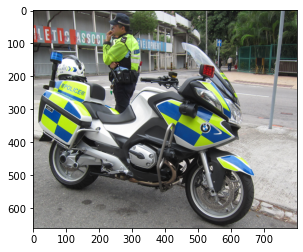

In [45]:
from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/test_resized.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

The endpoint accepts images in formats similar to the ones found images in the training dataset. The input `Content-Type` should be `image/jpeg`, and the output `Accept` type can be either:

- `image/png`, which produces an indexed-PNG segmentation mask as used in training: One predicted class ID per pixel... Or,
- `application/x-protobuf`, which produces a 3D matrix giving the *confidence of each class*, for each pixel.

In the SageMaker SDK, A `Predictor` has an associated **serializer** and **deserializer** which control how data gets translated to our API call, and loaded back into a Python result object.

There are pre-built [serializers](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) and [deserializers](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html) offered by the SDK, and we're free to define custom ones so long as they offer the same API.


### Basic inference - class IDs PNG

In our first example, we'll request the simple PNG response and would like to map those into pixel arrays (assigned class for each pixel)... So we'll write a custom deserializer for that:

In [101]:
# Just a pointer for diff endpoints
ss_predictor = tuner_transfer_learning_predictor

In [46]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

For the input our data is already stored as a JPEG file, so we'll use the built-in `IdentitySerializer` and feed it the file bytes:

In [47]:
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

With that configured, calling our endpoint is now simple!

In [48]:
%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(660, 799)
CPU times: user 15.2 ms, sys: 3.91 ms, total: 19.1 ms
Wall time: 21.2 s


Let us display the segmentation mask.

Since the raw value of each pixel is a small number (the class ID), we'll apply a [colormap](https://matplotlib.org/3.3.2/tutorials/colors/colormaps.html) to make it a bit more human readable and not just a black square!

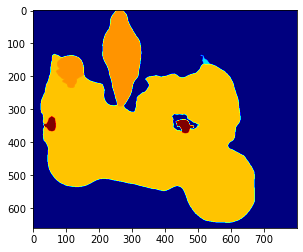

In [49]:
plt.imshow(cls_mask, cmap="jet")
plt.show()

In [50]:
# Original segementation before HPO
#plt.imshow(cls_mask, cmap="jet")
#plt.show()

### Advanced inference - class probabilities matrix

The second `Accept` type allows us to request all the class probabilities for each pixel.

Our input processing will be unchanged, but we'll define a new custom Deserializer to unpack the *RecordIO-wrapped protobuf* content returned by the endpoint.

This format takes a little more effort to convert into an array than the basic PNG response. In the code below, we:

- Make use of `mxnet` to open the [RecordIO](http://mesos.apache.org/documentation/latest/recordio/) wrapping
- Use the `record_pb2` utility from the SageMaker SDK to load the Record contents in [protocol buffers](https://github.com/protocolbuffers/protobuf) format
- Find that the record contains two fields `shape` (the shape of the matrix) and `target` (the probability predictions).
- Load the `target` matrix in usable numpy array format, and map its shape appropriately.


What we receive back is a recordio-protobuf of probablities sent as a binary. It takes a little bit of effort to convert into a readable array. Let us convert them to numpy format. We can make use of `mxnet` that has the capability to read recordio-protobuf formats. Using this, we can convert the outcoming bytearray into numpy array.

The protobuf array has two parts to it. The first part contains the shape of the output and the second contains the values of probabilites. Using the output shape, we can transform the probabilities into the shape of the image, so that we get a map of values. There typically is a singleton dimension since we are only inferring on one image. We can also remove that using the `squeeze` method.

In [51]:
import io
import tempfile

import mxnet as mx
from sagemaker.amazon.record_pb2 import Record


class SSProtobufDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize protobuf semantic segmentation response into a numpy array"""

    def __init__(self, accept="application/x-protobuf"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class confidences per pixel
        """
        try:
            rec = Record()
            # mxnet.recordio can only read from files, not in-memory file-like objects, so we buffer the
            # response stream to a file on disk and then read it back:
            with tempfile.NamedTemporaryFile(mode="w+b") as ftemp:
                ftemp.write(stream.read())
                ftemp.seek(0)
                recordio = mx.recordio.MXRecordIO(ftemp.name, "r")
                protobuf = rec.ParseFromString(recordio.read())
            values = list(rec.features["target"].float32_tensor.values)
            shape = list(rec.features["shape"].int32_tensor.values)
            # We 'squeeze' away extra dimensions introduced by the fact that the model can operate on batches
            # of images at a time:
            shape = np.squeeze(shape)
            mask = np.reshape(np.array(values), shape)
            return np.squeeze(mask, axis=0)
        finally:
            stream.close()


ss_predictor.deserializer = SSProtobufDeserializer()

In [52]:
%%time
prob_mask = ss_predictor.predict(imbytes)

print(type(prob_mask))
print(prob_mask.shape)

<class 'numpy.ndarray'>
(21, 660, 799)
CPU times: user 1.9 s, sys: 324 ms, total: 2.22 s
Wall time: 24.4 s


The assigned class labels from the previous method are equivalent to the *index of the maximum-confidence class*, for each pixel - so we should be able to reconstruct the same image as before by taking the `argmax` over the classes dimension:

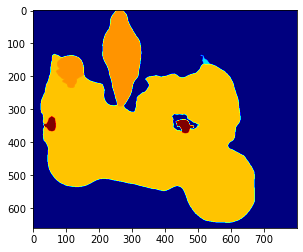

In [53]:
cls_mask_2 = np.argmax(prob_mask, axis=0)

plt.imshow(cls_mask_2, cmap="jet")
plt.show()

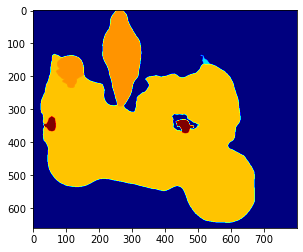

In [54]:
cls_mask_2 = np.argmax(prob_mask, axis=0)

plt.imshow(cls_mask_2, cmap="jet")
plt.show()

But this time, we can also view the *probabilities* for a particular class:

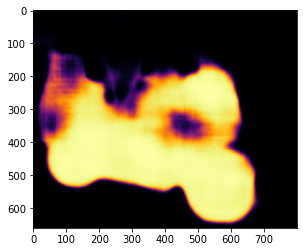

In [55]:
target_cls_id = 14  # (motorbike)
plt.imshow(prob_mask[target_cls_id, :, :], cmap="inferno")
plt.show()

...And perhaps generate an overlay image for easy human review:

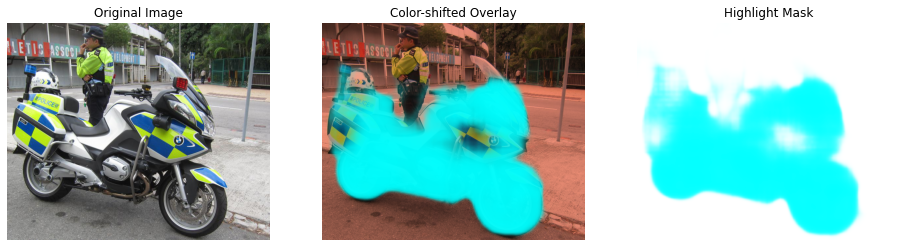

In [57]:
imarray = np.array(PIL.Image.open(filename)) / 255.0  # Convert image pixels from 0-255 to 0-1
hilitecol = np.array((0.0, 1.0, 1.0, 1.0))  # Cyan, 100% opacity (RGBAlpha 0-1 range)

# Red-shift our image to make the cyan highlights more obvious:
imshifted = imarray.copy()
imshifted[:, :, 1] *= 0.6
imshifted[:, :, 2] *= 0.5

# Construct a mask with alpha channel taken from the model result:
hilitemask = np.tile(hilitecol[np.newaxis, np.newaxis, :], list(imarray.shape[:2]) + [1])
hilitemask[:, :, 3] = prob_mask[target_cls_id, :, :]

# Overlay the two images:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 6))

ax0.imshow(imarray)
ax0.axis("off")
ax0.set_title("Original Image")
ax2.imshow(hilitemask)
ax2.axis("off")
ax2.set_title("Highlight Mask")

ax1.imshow(imshifted)
ax1.imshow(hilitemask)
ax1.axis("off")
ax1.set_title("Color-shifted Overlay")

plt.show()

## Delete the Endpoint

Deployed endpoints are backed by infrastructure (1x`ml.c5.xlarge` in our case, as we requested above) - so we should delete the endpoint when we're finished with it, to avoid incurring continued costs.

In [111]:
ss_predictor.delete_endpoint()